# XGBoost

Training model to predict whether patient dies, or not.

1) binary model (dead, not dead)
2) multi-class classification model and using just the mRS6 classification outcome

## Import libraries

In [143]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

import pickle
import shap

from os.path import exists

import math

from sklearn.metrics import accuracy_score

import importlib
# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

import time

Report the time duration to run notebook

In [144]:
start_time = time.time()

## Set up paths and filenames

In [145]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

  #  data_path: str = '../'
  #  data_filename: str = 'SAMueL ssnap extract v2.csv'
  #  data_save_path: str = './'
  #  data_save_filename: str = 'reformatted_data.csv'
  #  database_filename: str = 'samuel.db'
  #  notebook: str = '01'
  #  kfold_folder: str = 'data/kfold_5fold/'

    data_read_path: str = '../data/'
    data_read_filename: str = '02_reformatted_data_ml_230612.csv'
 #   data_save_path: str = './kfold_5fold'
#    data_save_filename: str = 'train.csv'
    notebook: str = '230725_'
    model_text: str = 'xgb_all_data_binary'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [146]:
filename = paths.data_read_path + paths.data_read_filename
data = pd.read_csv(filename)

Want to use onset to thrombolysis time in the model. Define function to calculate the feature.

In [147]:
def calculate_onset_to_thrombolysis(row):
    # Set default value of onset to thrombolysis of -100 (no thrombolysis given)
    onset_to_thrombolysis = -100
    # Set value if thrombolysis given
    if  row['scan_to_thrombolysis_time'] != -100:
        onset_to_thrombolysis = (row['onset_to_arrival_time'] + 
        row['arrival_to_scan_time'] + row['scan_to_thrombolysis_time'])
    return onset_to_thrombolysis

In [148]:
# Calculate onset to thgrombolysis (but set to -100 if no thrombolysis given)
data['onset_to_thrombolysis_time'] = data.apply(calculate_onset_to_thrombolysis, axis=1)
data.drop(['scan_to_thrombolysis_time', 'arrival_to_scan_time',
        'onset_to_arrival_time'], axis=1, inplace=True)

Get list of features

In [149]:
features = list(data)
print(f"There are {len(features)} features")

There are 54 features


Calculate the binary outcome: Dead or not dead

In [150]:
data["discharge_mrs6"] = 0
mask = data["discharge_disability"] == 6
data["discharge_mrs6"][mask] = 1

Extract features

In [151]:
selected_features = ['prior_disability','stroke_severity','stroke_team',
                     'onset_to_thrombolysis_time','age']
X_data = data[selected_features]

Extract two target features (one for binary model, one for multiclass model)

In [152]:
y_data_mc = data['discharge_disability']
y_data_bin = data['discharge_mrs6']

Check the balance of classes for the target feature

In [153]:
proportion_die = y_data_bin.value_counts()[1]/y_data_bin.shape[0]
print(f'Percent of patients with death as six month outcome: {proportion_die*100}%')

Percent of patients with death as six month outcome: 12.480952775634854%


In [154]:
y_data_bin.value_counts()

0    137271
1     19576
Name: discharge_mrs6, dtype: int64

A model that classifies all as alive will have an accuracy of 87.5%. We hope that a model can improve on this.

One hot the categorical feature (stroke team).

Define a function

In [155]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [156]:
X_data = convert_feature_to_one_hot(X_data, "stroke_team", "team")

Get list of features in dataset, post one hot encoding.

In [157]:
features_ohe = list(X_data)

Function to calculate some accuracy measures (returns a dataframe)

In [158]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)

    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
       
    sensitivity = np.sum(true_positives) / np.sum(observed_positives)
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['accuracy'] = np.mean(predicted == observed)
    
    return results

Divide into training and test sets

When we test a machine learning model we should always test it on data that has not been used to train the model. We will use sklearn's train_test_split method to randomly split the data: 75% for training, and 25% for testing.

Use multiclass target feature for the split, then convert to the binary target feature (to ensure match of patient data)

In [159]:
X_train, X_test, y_train_mc, y_test_mc = train_test_split(X_data, y_data_mc, test_size = 0.25)

In [160]:
def create_binary_target(y_test_mc):
    y_test_bin = pd.Series(0, name='discharge_mrs6',index=y_test_mc.index)
    mask = y_test_mc == 6
    y_test_bin[mask] = 1
    return(np.array(y_test_bin))

In [161]:
y_train_bin = create_binary_target(y_train_mc)
y_test_bin = create_binary_target(y_test_mc)

## Model 1: Predict binary death (use default threshold, 0.5)

Fit XGBoost model, train model with all data

In [162]:
def fit_xgboost(X_data, y_data, filename):
    
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # load model
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:        

        # Define model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_data, y_data)

        # Save model
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

In [163]:
model_bin = fit_xgboost(X_train, y_train_bin, 
                        f"{paths.notebook}{paths.model_text}_bin.p")

In [164]:
def calculate_predicted_probabilities(model, X_data):
    y_probs = model.predict_proba(X_data)
    y_pred = model.predict(X_data)
    return(y_probs, y_pred)

In [165]:
(y_probs_bin, y_pred_bin) = calculate_predicted_probabilities(model_bin, X_test)

Show accuracy (identity)

In [166]:
accuracy = calculate_accuracy(y_test_bin, y_pred_bin)
print (f'Accuracy (binary model): {accuracy["accuracy"]:0.2f}')
print (f'Sensitivity (binary model): {accuracy["sensitivity"]:0.2f}')
print (f'Specificity (binary model): {accuracy["specificity"]:0.2f}')

Accuracy (binary model): 0.89
Sensitivity (binary model): 0.35
Specificity (binary model): 0.97


In [283]:
cm = confusion_matrix(y_test_bin, y_pred_bin)
cm.max()

33275

In [284]:
def plot_confusion_matrix(y_data, y_pred, xlabel, ylabel, title, vmax="",
                          ax=""):

    # Show confusion matrix
    cm = confusion_matrix(y_data, y_pred)
    if vmax=="":
        vmax = cm.max()
    # Visualize the confusion matrix with colors

    if ax == "":
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
    heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower', vmax=vmax)
    colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax, alpha=0.5, label='Count')

    # To add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, cm[i][j], ha='center', va='center', color='r')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return(ax)

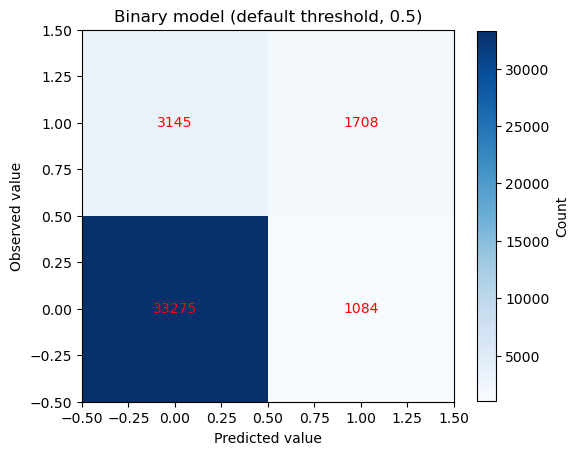

In [285]:
plot_confusion_matrix(y_test_bin, y_pred_bin, 
                      'Predicted value', 'Observed value', 
                      'Binary model (default threshold, 0.5)');

## Receiver Operator Characteristic and Sensitivity-Specificity Curves

### Receiver Operator Characteristic Curve:

In [169]:
def calculate_auc(y_data, y_probs):
    fpr, tpr, thresholds = roc_curve(y_data, y_probs)
    roc_auc = auc(fpr, tpr)
    return(fpr, tpr, thresholds, roc_auc)

In [170]:
(fpr_bin, tpr_bin, thresholds_bin, roc_auc_bin) = calculate_auc(y_test_bin, y_probs_bin[:,1])

# Show area under curve  
print (f'\nAUC: {roc_auc_bin:0.4f}')


AUC: 0.8576


Calculate data for sensitivity-specificity curve:

In [171]:
def calculate_sensitivity_specificity(y_data, y_probs):
    sensitivity = []
    specificity = []

    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = y_probs >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_data, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])

    return(sensitivity, specificity, thresholds)

In [172]:
(sensitivity_bin, specificity_bin, thresholds_bin) = (
            calculate_sensitivity_specificity(y_test_bin, y_probs_bin[:,1]))

Create a combined plot: ROC and sensitivity-specificity

In [173]:
def plot_roc_and_sen_spec(fpr, tpr, roc_auc, sensitivity, specificity, filename):
    
    fig = plt.figure(figsize=(10,5))

    # Plot ROC
    ax1 = fig.add_subplot(121)
    ax1.plot(fpr, tpr, color='orange')
    ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operator Characteristic Curve')
    text = f'AUC: {roc_auc:.3f}'
    ax1.text(0.64,0.07, text, 
            bbox=dict(facecolor='white', edgecolor='black'))
    plt.grid(True)

    # Plot sensitivity-specificity
    ax2 = fig.add_subplot(122)
    ax2.plot(sensitivity, specificity)
    ax2.set_xlabel('Sensitivity')
    ax2.set_ylabel('Specificity')
    ax2.set_title('Sensitivity-Specificity Curve')
    plt.grid(True)


    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300)

    plt.show()

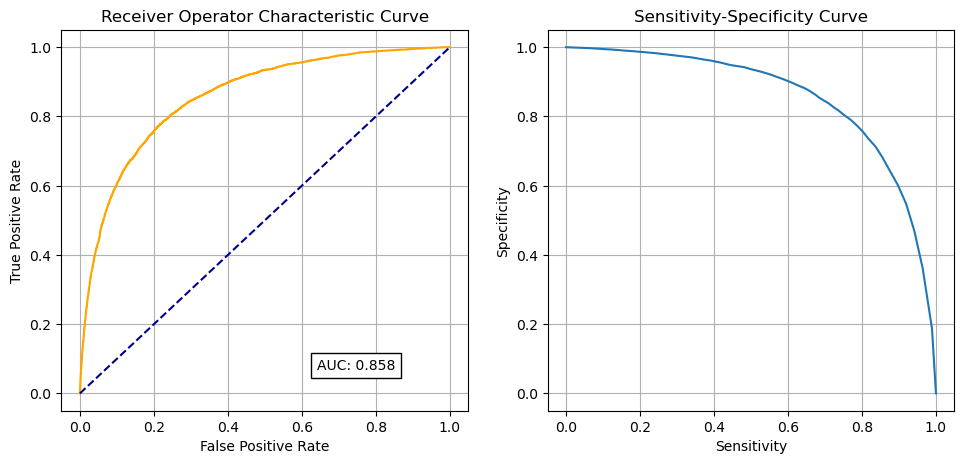

In [174]:
filename_bin = f"{paths.notebook}{paths.model_text}_bin_roc_sens_spec.jpg"
plot_roc_and_sen_spec(fpr_bin, tpr_bin, roc_auc_bin, 
                      sensitivity_bin, specificity_bin, filename_bin)

Identify cross-over point on sensitivity-specificity curve
Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [175]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [176]:
def create_intersect_parameters(sensitivity, specificity):
    df = pd.DataFrame()
    df['sensitivity'] = np.array(sensitivity)
    df['specificity'] = np.array(specificity)
    df['spec greater sens'] = df['specificity'] > df['sensitivity']

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    return(a1, a2, b1, b2)

In [177]:
(a1, a2, b1, b2) = create_intersect_parameters(sensitivity_bin, specificity_bin)

intersection_bin = get_intersect(a1, a2, b1, b2)[0]

print (f'\nIntersection: {intersection_bin:0.4f}')


Intersection: 0.7801


Calibration

In [178]:
def calculate_reliability_results(observed, probability):
    # Get observed class and predicted probability
#    observed = y_data_bin
#    probability = y_probs_bin

    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(probability, bins)
        
    # Put results in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = probability
    reliability['observed'] = observed
    classification = 1 * (probability > 0.5 )
    reliability['correct'] = observed == classification
    reliability['count'] = 1

    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']

    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']

    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]
    
    return(reliability_summary)

In [233]:
def plot_callibration(reliability_summary):
    # Plot
    fig = plt.figure(figsize=(10,5))

    # Plot predicted prob vs fraction psotive
    ax1 = fig.add_subplot(1,1,1)

    # Loop through k-fold reliability results
    x = reliability_summary['confidence']
    y = reliability_summary['fraction_positive']
    ax1.plot(x,y, color='orange')
    # Add 1:1 line
    ax1.plot([0,1],[0,1], color='k', linestyle ='--')
    # Refine plot
    ax1.set_xlabel('Model probability')
    ax1.set_ylabel('Fraction positive')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    ax1.grid()


    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    x = reliability_summary['confidence']
    y = reliability_summary['fraction_results']
    ax2.plot(x,y, color='blue')
        
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 0.8)
    ax2.set_ylabel('Fraction of samples')

    custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                    Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

    ax1.grid()

    plt.legend(custom_lines, ['Fraction positive', 'Fraction of samples'],
            loc='upper center')

    plt.tight_layout(pad=2)

#    plt.savefig(f'./output/{notebook}_{model_text}_reliability.jpg', dpi=300)
    plt.show()

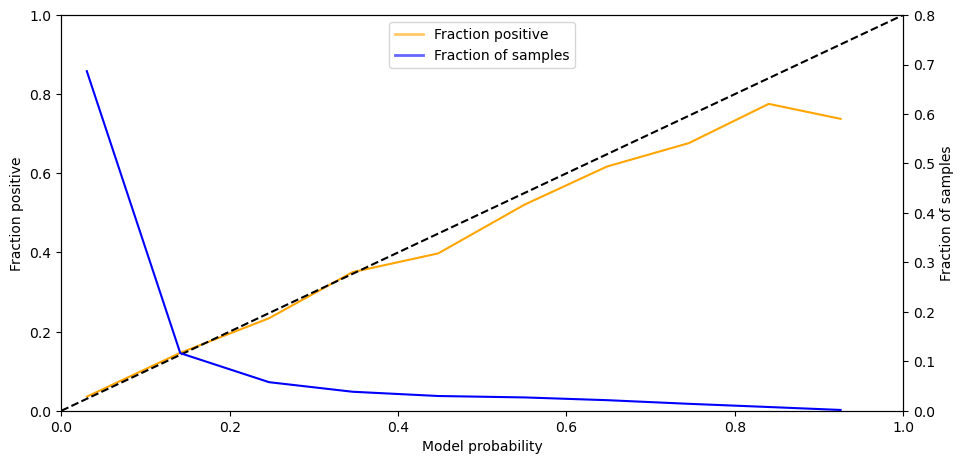

In [234]:
reliability_summary = calculate_reliability_results(y_test_bin, 
                                                    y_probs_bin[:,1])
plot_callibration(reliability_summary)

In [181]:
observed = np.array(y_test_bin)
probability = y_probs_bin[:,1]

# Get observed class and predicted probability
#    observed = y_data_bin
#    probability = y_probs_bin

# Bin data with numpy digitize (this will assign a bin to each case)
step = 0.10
bins = np.arange(step, 1+step, step)
digitized = np.digitize(probability, bins)
    
# Put results in DataFrame
reliability = pd.DataFrame()
reliability['bin'] = digitized
reliability['probability'] = probability
reliability['observed'] = observed
classification = 1 * (probability > 0.5 )

reliability['correct'] = observed == classification
reliability['count'] = 1


In [182]:
# Summarise data by bin in new dataframe
reliability_summary = pd.DataFrame()

# Add bins and k-fold to summary
reliability_summary['bin'] = bins

# Calculate mean of predicted probability of thrombolysis in each bin
reliability_summary['confidence'] = \
    reliability.groupby('bin').mean()['probability']

# Calculate the proportion of patients who receive thrombolysis
reliability_summary['fraction_positive'] = \
    reliability.groupby('bin').mean()['observed']

In [183]:
# Calculate proportion correct in each bin
reliability_summary['fraction_correct'] = \
    reliability.groupby('bin').mean()['correct']

In [184]:
# Calculate fraction of results in each bin
reliability_summary['fraction_results'] = \
    reliability.groupby('bin').sum()['count'] / reliability.shape[0]

## Model 2: Predict binary death (use threshold for sensitivity v. specificity intersection)

#### Fit XGBoost model, train model with all data

Identify the threshold that gave this intersection.

In [185]:
#min(enumerate(sensitivity), key=lambda x: abs(x[1]-intersection))
threshold_intersection_bin = min(range(len(sensitivity_bin)), 
                             key=lambda i: abs(sensitivity_bin[i]-intersection_bin))

Confusion matrix with this threshold

In [186]:
y_pred_intersection_bin = (
    y_probs_bin[:,1] > thresholds_bin[threshold_intersection_bin])

accuracy = calculate_accuracy(y_test_bin, y_pred_intersection_bin)

print (f'Accuracy (binary model) [intersect threshold '
       f'{thresholds_bin[threshold_intersection_bin]:0.4f}]: '
       f'{accuracy["accuracy"]:0.2f}')
print (f'Sensitivity (binary model) [intersect threshold '
       f'{thresholds_bin[threshold_intersection_bin]:0.4f}]: '
       f'{accuracy["sensitivity"]:0.2f}')
print (f'Specificity (binary model) [intersect threshold '
       f'{thresholds_bin[threshold_intersection_bin]:0.4f}]: '
       f'{accuracy["specificity"]:0.2f}')

Accuracy (binary model) [intersect threshold 0.1100]: 0.78
Sensitivity (binary model) [intersect threshold 0.1100]: 0.79
Specificity (binary model) [intersect threshold 0.1100]: 0.77


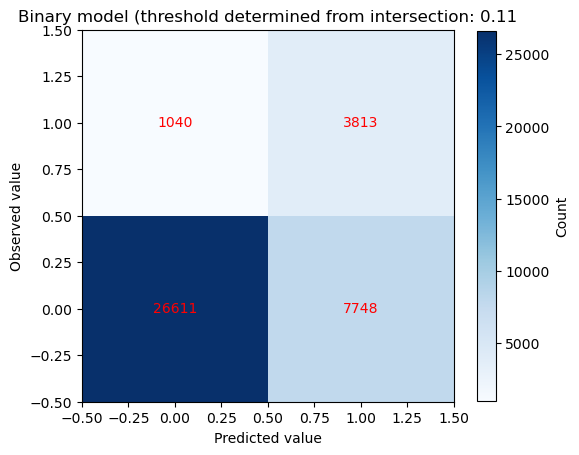

In [250]:
title = (f'Binary model (threshold determined from intersection: '
         f'{thresholds_bin[threshold_intersection_bin]:0.2f}')

plot_confusion_matrix(y_test_bin, y_pred_intersection_bin, 
                      'Predicted value', 'Observed value', 
                      title);

## Model 3: Predict multiclass death (use default threshold, 0.5)

#### Fit XGBoost model, train model with all data

In [188]:
model_mc = fit_xgboost(X_train, y_train_mc, f"{paths.notebook}{paths.model_text}_mc.p")

In [189]:
(y_probs_mc, y_pred_mc) = calculate_predicted_probabilities(model_mc, X_test)

Get just the probability for death (outcome 6)

In [190]:
y_pred_mc6 = y_probs_mc[:,6] > 0.5

Calculate model accuracy

In [191]:
accuracy_mc = calculate_accuracy(y_test_bin, y_pred_mc6)
print (f'Accuracy ((multiclass) [default threshold]: {accuracy_mc["accuracy"]:0.2f}')
print (f'Sensitivity (multiclass) [default threshold]: {accuracy_mc["sensitivity"]:0.2f}')
print (f'Specificity (multiclass) [default threshold]: {accuracy_mc["specificity"]:0.2f}')

Accuracy ((multiclass) [default threshold]: 0.89
Sensitivity (multiclass) [default threshold]: 0.34
Specificity (multiclass) [default threshold]: 0.97


Confusion matrix

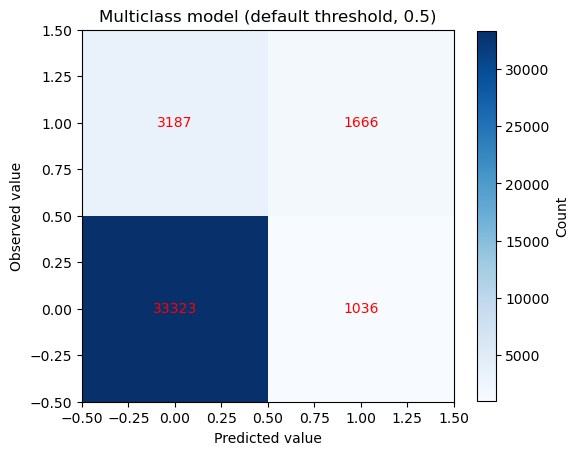

In [251]:
plot_confusion_matrix(y_test_bin, y_pred_mc6, 
                      'Predicted value', 'Observed value', 
                      'Multiclass model (default threshold, 0.5)');

Do the two different models (binary vs multiclass) predict the same outcome for each individual patient (when use default threshold, 0.5)?

Plot a confusion matrix

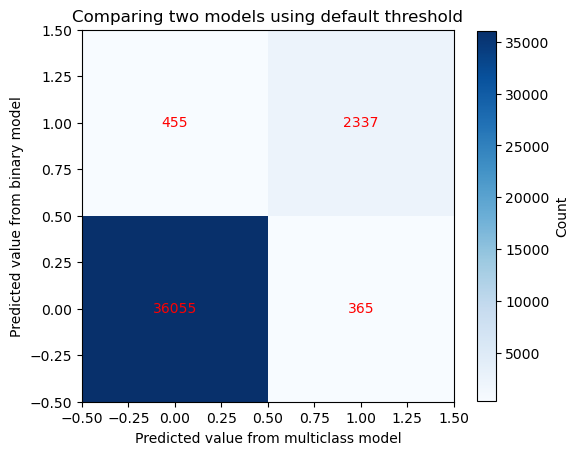

In [252]:
plot_confusion_matrix(y_pred_bin, y_pred_mc6, 
                      'Predicted value from multiclass model', 
                      'Predicted value from binary model', 
                      'Comparing two models using default threshold');

We don't know which of these patients are correctly classified.

Plot a confusion matrix of confusion matrices. For each individual confusion matrix limit the patients by whether they are classified correctly by the two models.

In [ ]:
def cm_of_cms(y_pred_bin, y_pred_mc6, y_test_bin):
    """
    y_pred_bin (array): classification of instances from the binary model
    y_pred_mc6 (array): classification of instances from the multiclass model 
                        (for death output only)
    y_test_bin (array): observed classification fo instances
    """
    
    # Categorise each patient by which of the two models correctly classified them
    # Give new label "category", where:
    # 10 only bin correct
    # 11 bin and mc correct
    # 01 only mc correct
    # 00 neither correct

    bin_correct = y_pred_bin == y_test_bin
    mc_correct = y_pred_mc6 == y_test_bin

    category = bin_correct * 10 + mc_correct

    plt.figure(figsize = (20, 20))

    for i in np.unique(category):
        mask = category == i
        binary_result = y_pred_bin[mask]
        mc_result = y_pred_mc6[mask]

        if i == 10:
            title = 'Comparing two models using intersection threshold\n(these patients are only correctly classified by the binary model)'
            ax = plt.subplot(2, 2, 1)
        if i == 11:
            title = 'Comparing two models using intersection threshold\n(these patients are correctly classified by both models)'
            ax = plt.subplot(2, 2, 2)
        if i == 0:
            title = 'Comparing two models using intersection threshold\n(these patients are incorrectly classified by both models)'
            ax = plt.subplot(2, 2, 3)
        if i == 1:
            title = 'Comparing two models using intersection threshold\n(these patients are only correctly classified by the multiclass models)'
            ax = plt.subplot(2, 2, 4)
        plot_confusion_matrix(binary_result, mc_result, 
                        'Predicted value from multiclass model',
                        'Predicted value from binary model',
                        title, ax=ax, vmax=27000)

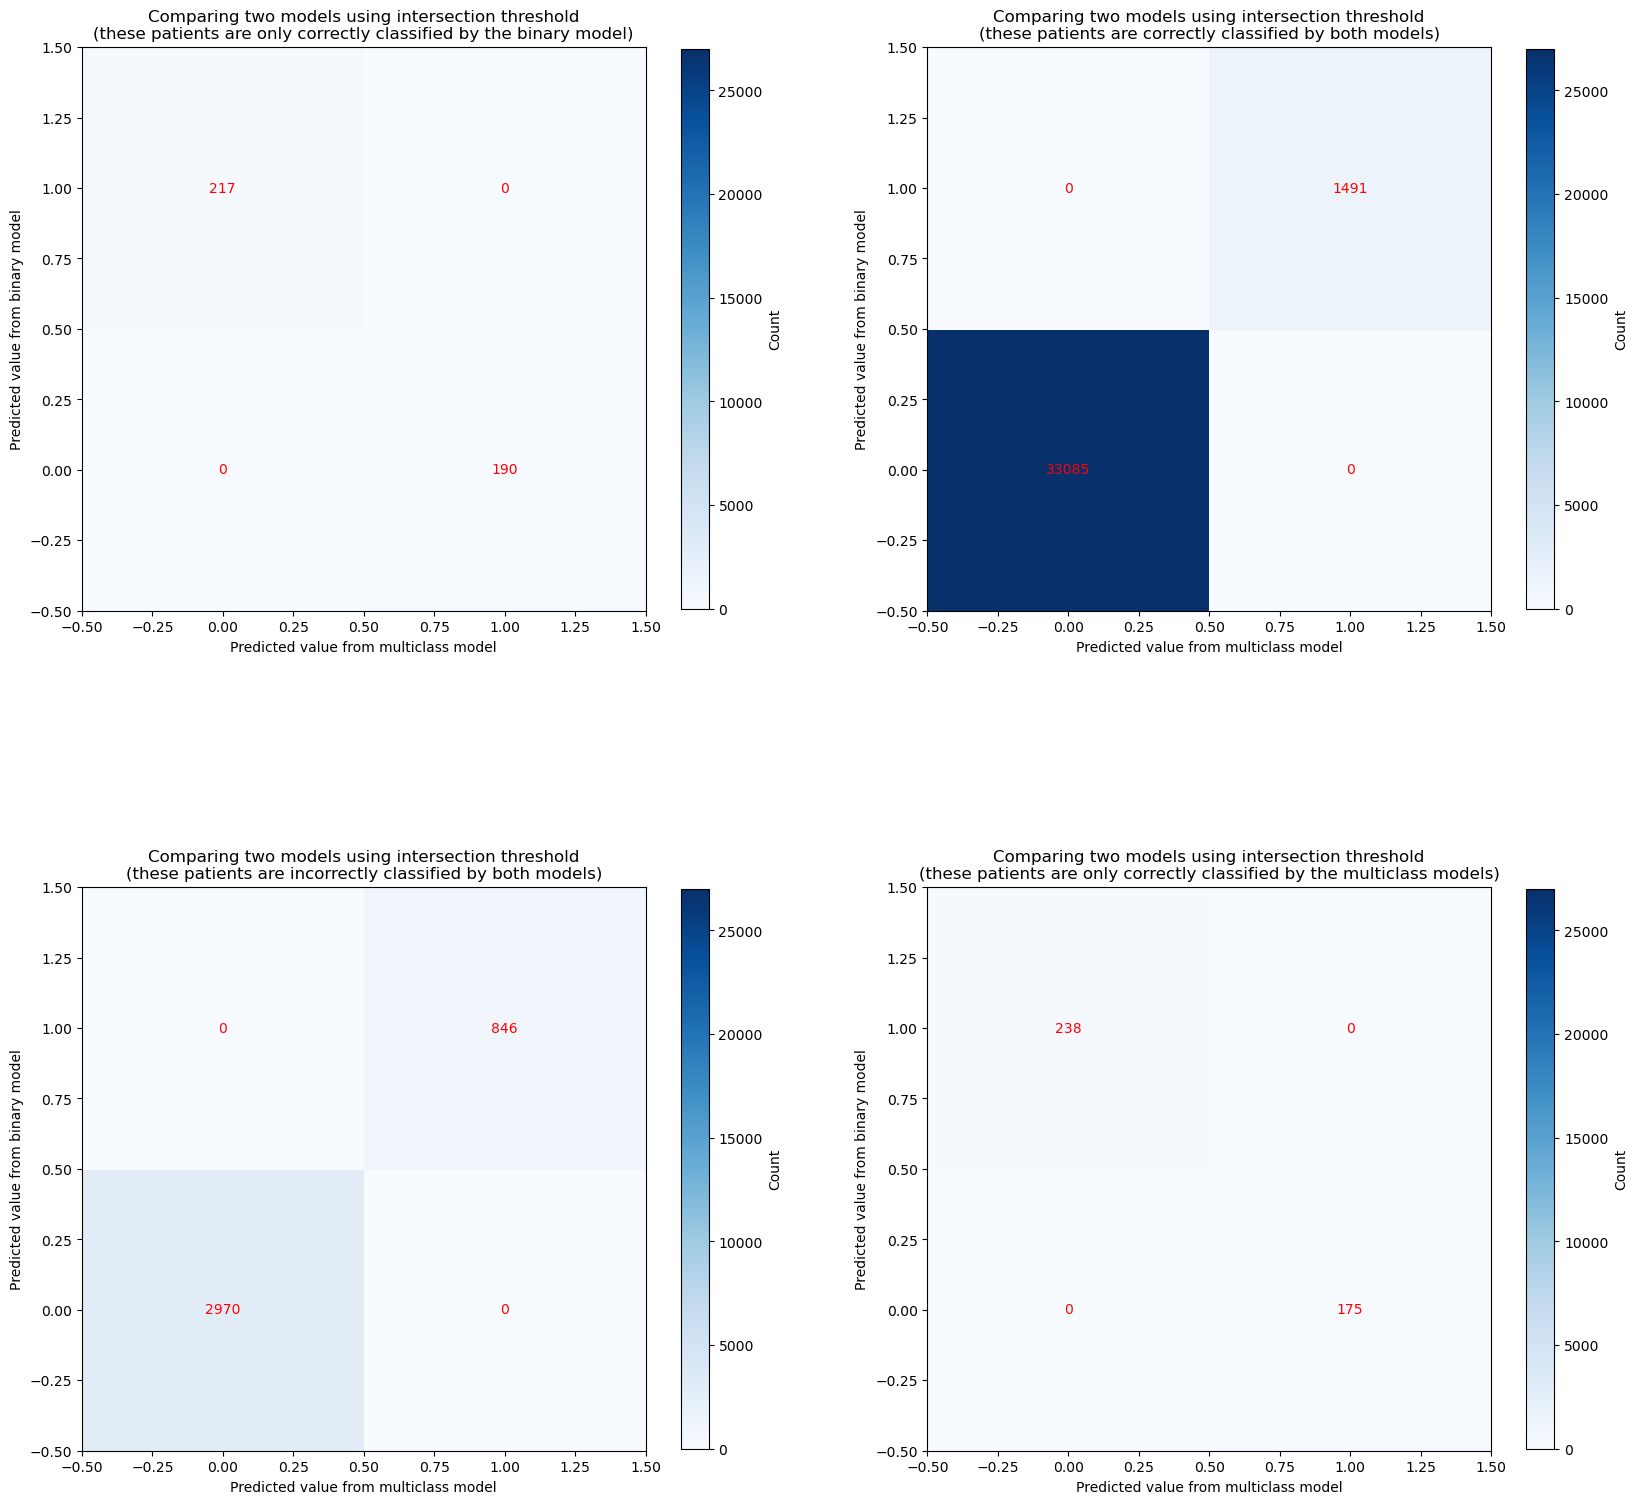

In [290]:
cm_of_cms(y_pred_bin, y_pred_mc6, y_test_bin)

ROC AUC

In [220]:
(fpr_mc, tpr_mc, thresholds_mc, roc_auc_mc) = calculate_auc(y_test_bin, y_probs_mc[:,6])

# Show area under curve  
print (f'\nAUC: {roc_auc_mc:0.4f}')


AUC: 0.8614


In [195]:
(sensitivity_mc, specificity_mc, thresholds_mc) = calculate_sensitivity_specificity(y_test_bin, y_probs_mc[:,6])

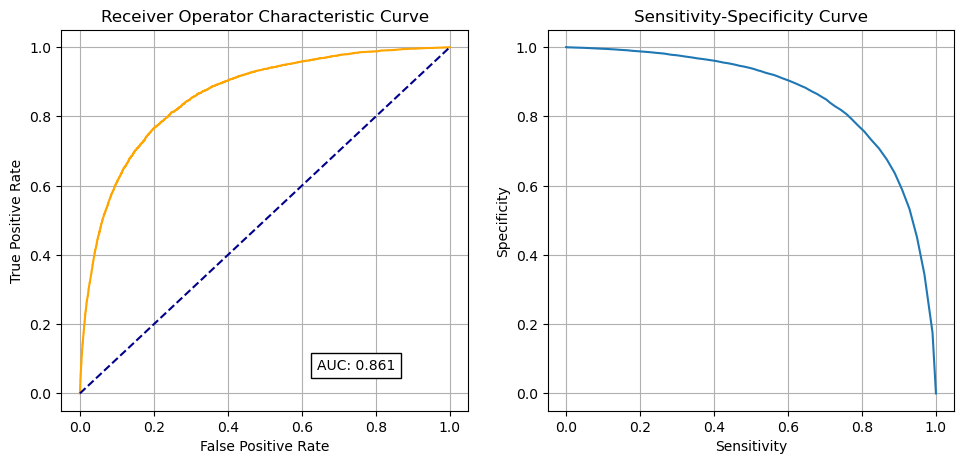

In [196]:
filename_mc = f"{paths.notebook}{paths.model_text}_mc_roc_sens_spec.jpg"
plot_roc_and_sen_spec(fpr_mc, tpr_mc, roc_auc_mc, 
                      sensitivity_mc, specificity_mc, filename_mc)

In [197]:
(a1, a2, b1, b2) = create_intersect_parameters(sensitivity_mc, specificity_mc)

intersection_mc6 = get_intersect(a1, a2, b1, b2)[0]

print (f'\nIntersection: {intersection_mc6:0.4f}')


Intersection: 0.7819


Calibration

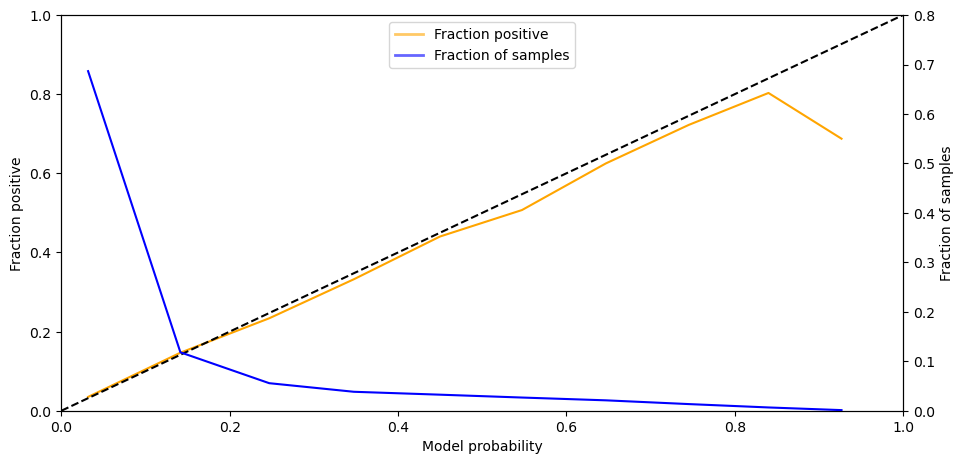

In [235]:
reliability_summary_mc6 = (
                calculate_reliability_results(y_test_bin, y_probs_mc[:,6]))
plot_callibration(reliability_summary_mc6)

## Model 4: Predict multiclass death (use threshold for sensitivity v. specificity intersection)

#### Fit XGBoost model, train model with all data

Find threshold to give this intersection

In [199]:
threshold_intersection_mc6 = min(range(len(sensitivity_mc)), 
                             key=lambda i: abs(sensitivity_mc[i]-intersection_mc6))

In [201]:
y_pred_intersection_mc6 = y_probs_mc[:,6] > thresholds_mc[threshold_intersection_mc6]

accuracy = calculate_accuracy(y_test_bin, y_pred_intersection_mc6)
print (f'Accuracy (binary model) [intersect threshold {thresholds_mc[threshold_intersection_mc6]:0.2f}]: {accuracy["accuracy"]:0.2f}')
print (f'Sensitivity (binary model) [intersect threshold {thresholds_mc[threshold_intersection_mc6]:0.2f}]: {accuracy["sensitivity"]:0.2f}')
print (f'Specificity (binary model) [intersect threshold {thresholds_mc[threshold_intersection_mc6]:0.2f}]: {accuracy["specificity"]:0.2f}')

Accuracy (binary model) [intersect threshold 0.1100]: 0.78
Sensitivity (binary model) [intersect threshold 0.1100]: 0.79
Specificity (binary model) [intersect threshold 0.1100]: 0.78


Confusion matrix with this threshold

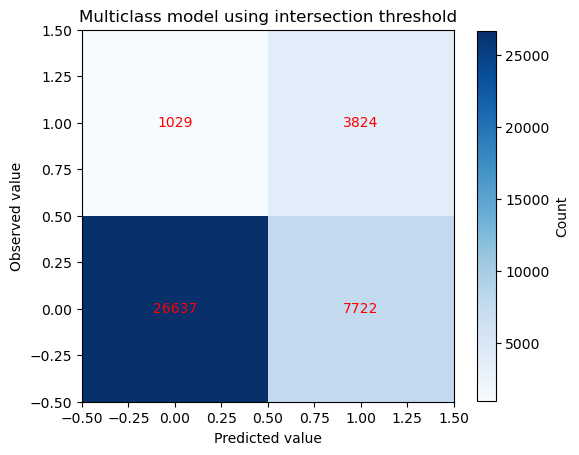

In [254]:
plot_confusion_matrix(y_test_bin, y_pred_intersection_mc6, 
                      'Predicted value', 
                      'Observed value', 
                      'Multiclass model using intersection threshold');

Do the two different models (binary vs multiclass) predict the same outcome for each individual patient (when use the threshold to give intersect for sensitivity and specificity)?

Plot a confusion matrix

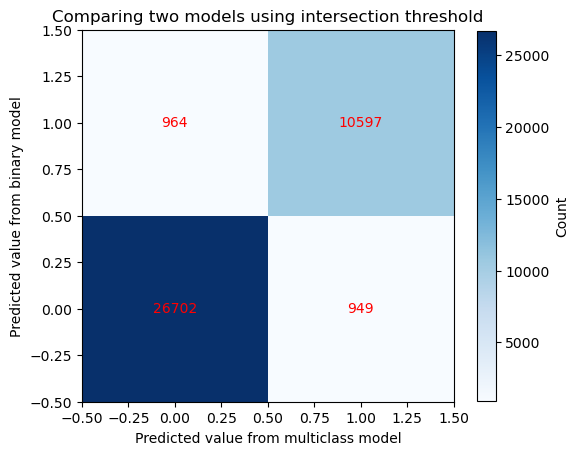

In [255]:
plot_confusion_matrix(y_pred_intersection_bin, y_pred_intersection_mc6, 
                      'Predicted value from multiclass model',
                      'Predicted value from binary model',
                      'Comparing two models using intersection threshold');

We don't know which of these patients are correctly classified.

Plot a confusion matrix of confusion matrices. For each individual confusion matrix limit the patients by whether they are classified correctly by the two models.

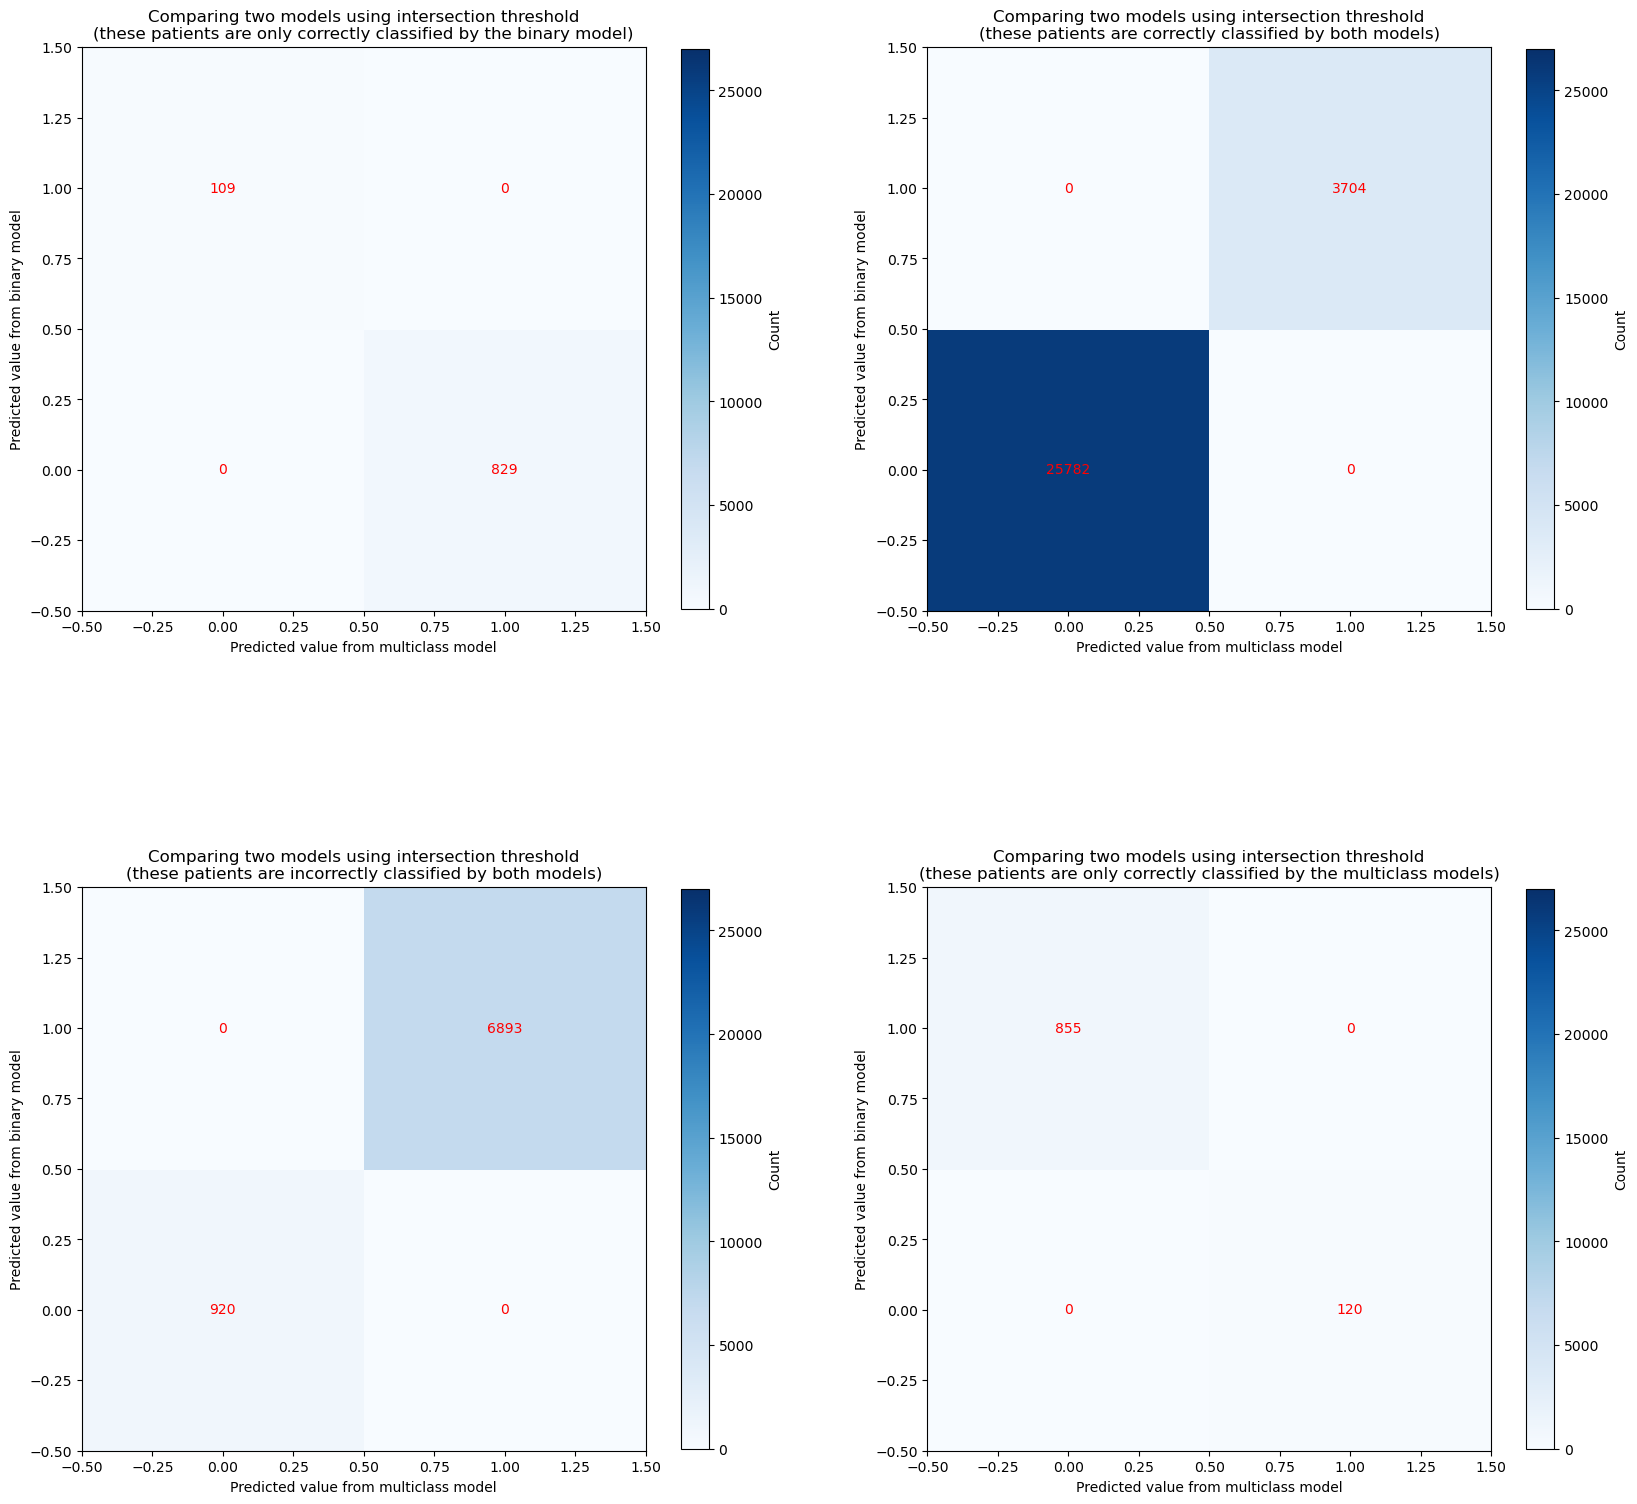

In [289]:
cm_of_cms(y_pred_intersection_bin, y_pred_intersection_mc6, y_test_bin)

In [265]:
df_temp = pd.DataFrame({'y_pred_intersection_bin':y_pred_intersection_bin,
                        'y_pred_intersection_mc6':y_pred_intersection_mc6,
                        'y_test_bin':y_test_bin})
df_temp

,y_pred_intersection_bin,y_pred_intersection_mc6,y_test_bin
0,True,True,0
1,True,True,0
2,True,True,0
3,False,False,0
4,False,False,0
...,...,...,...
39207,False,False,0
39208,False,False,0
39209,False,False,0
39210,False,False,0


In [267]:
bin_correct = y_pred_intersection_bin == y_test_bin
mc_correct = y_pred_intersection_mc6 == y_test_bin

In [271]:
category = bin_correct * 10 + mc_correct

In [276]:
(category==11).sum()

29486

In [ ]:

plt.figure(figsize = (20, 20))

for i in np.unique(category):
    mask = category == i
    observed = y_test_bin[mask]
    predicted = y_pred_bin[mask]

    if i == 10:
        title = 'Comparing two models using intersection threshold\n(these patients are only correctly classified by the binary model)'
        ax = plt.subplot(2, 2, 1)
    if i == 11:
        title = 'Comparing two models using intersection threshold\n(these patients are correctly classified by both models)'
        ax = plt.subplot(2, 2, 2)
    if i == 0:
        title = 'Comparing two models using intersection threshold\n(these patients are incorrectly classified by both models)'
        ax = plt.subplot(2, 2, 3)
    if i == 1:
        title = 'Comparing two models using intersection threshold\n(these patients are only correctly classified by the multiclass models)'
        ax = plt.subplot(2, 2, 4)
    plot_confusion_matrix(observed, predicted, 
                      'Predicted value from multiclass model',
                      'Predicted value from binary model',
                      title, ax=ax)

## Summary section. Looking at the four performance confusion matrices together.

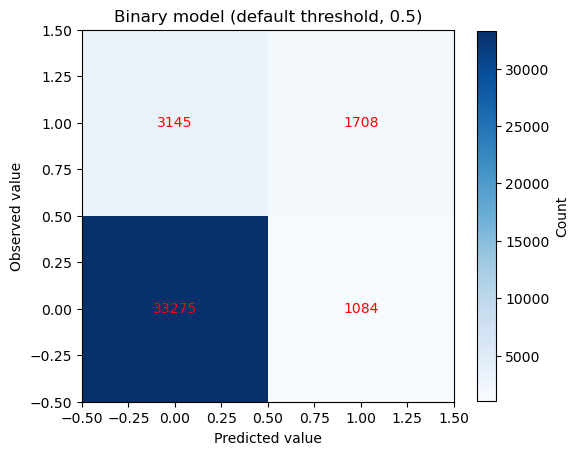

In [205]:
plot_confusion_matrix(y_test_bin, y_pred_bin, 
                      'Predicted value', 'Observed value', 
                      'Binary model (default threshold, 0.5)')

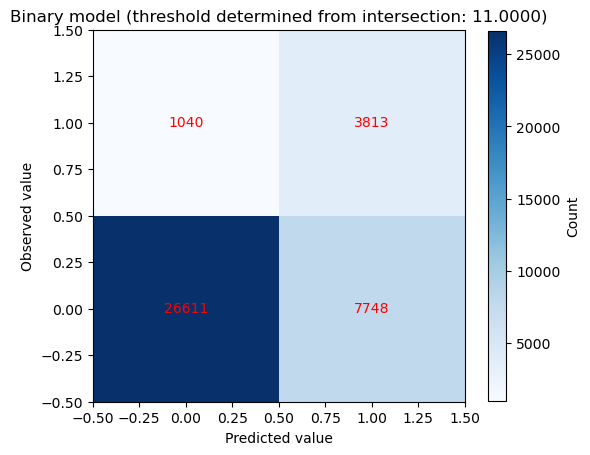

In [206]:
plot_confusion_matrix(y_test_bin, y_pred_intersection_bin, 
                      'Predicted value', 'Observed value', 
                      f'Binary model (threshold determined from intersection: {threshold_intersection_bin:0.4f})')

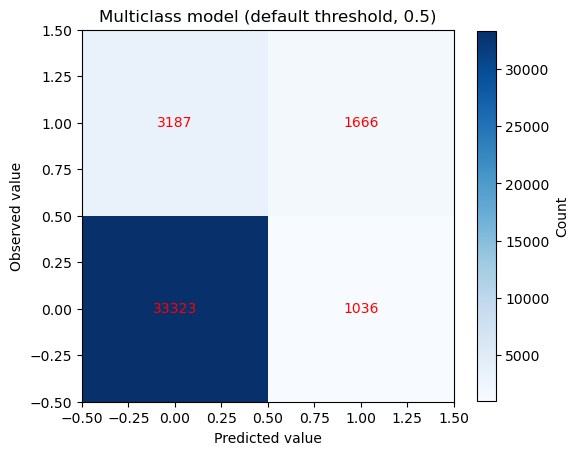

In [210]:
plot_confusion_matrix(y_test_bin, y_pred_mc6, 
                      'Predicted value', 'Observed value', 
                      'Multiclass model (default threshold, 0.5)')

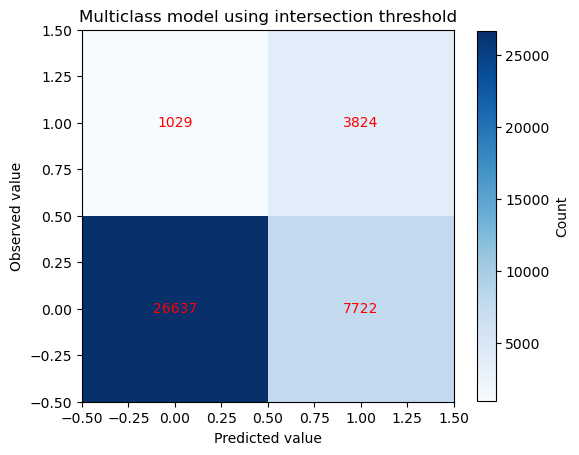

In [208]:
plot_confusion_matrix(y_test_bin, y_pred_intersection_mc6, 
                      'Predicted value', 
                      'Observed value', 
                      'Multiclass model using intersection threshold')

In [209]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 1680.3927810192108
